# Goals

  * sentiment analysis on twitter thread interactions.
  * train a model to be able to predict conversation sentiment.

      * based on the first tweet?
      * proactive measures for dealing with customers.


In [49]:
!pip install -q kaggle
from google.colab import files 
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d thoughtvector/customer-support-on-twitter

#in drive https://drive.google.com/drive/u/1/folders/1Sh4w-8e1p2Yl_9QrAvpgRf4nmeY_KW-z

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
customer-support-on-twitter.zip: Skipping, found more recently modified local copy (use --force to force download)


In [50]:
!pip install cloudmesh-installer
!pip install cloudmesh-common 

## Import libraries

In [51]:
import time
from cloudmesh.common.StopWatch import StopWatch
from cloudmesh.common.Benchmark import Benchmark
from cloudmesh.common.Shell import Shell

import zipfile 

#dealing with data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import sklearn
from sklearn.model_selection import train_test_split

#nl libraries
import string 
import nltk #natural language tool kit
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
nltk.download('punkt')



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Download and reduce the data working with

In [52]:
StopWatch.start("get_data")

zfile=zipfile.ZipFile('/content/customer-support-on-twitter.zip')
data=pd.read_csv(zfile.open('twcs/twcs.csv')) 

StopWatch.stop("get_data")

print(data.shape)
data.head()

StopWatch.start("manageability")

df=data.drop(['inbound','created_at'],axis=1)
df["text"]=df["text"].astype(str)
df.sample(frac=1)
df=df.head(650) 
StopWatch.stop("manageability")


(2811774, 7)


In [53]:
StopWatch.start("removing_companies")

#companies are not anon so they have actual letters
def companies(df):
  idx=[]
  for id in range(len(df["author_id"])):
    #assuming at least one vowel in each company name
      vowels=['a','e','i','o', 'u']
      for vowel in vowels:
        if vowel in df["author_id"][id]:
          idx.append(id)
          break 
  return df.drop(idx)

#we only want the consumer side 
customers=companies(df)

StopWatch.stop("removing_companies")

# Analyze senitment for individual tweets

In [54]:
StopWatch.start("sentiment_score")

sent_analyzer=SentimentIntensityAnalyzer()

#analyze the raw tweets
customers["sentiment"]=customers["text"].apply(lambda x: sent_analyzer.polarity_scores(x)["compound"])

StopWatch.stop("sentiment_score")

# Build a new dataframe

In [55]:
# #show distribution of overall tweets and by customers
cust_average=customers.groupby("author_id")
cust_sent_average=cust_average.sentiment.mean()
cust_sent_average=pd.DataFrame({'author_id':cust_sent_average.index, 'sentiment_average': cust_sent_average.values})

#getting the first tweet for each author
customers = customers[pd.isnull(df.in_response_to_tweet_id)]

#new dataframe with the essentials
customer_first=pd.DataFrame({'author_id':customers['author_id'], 
                             'tweet':customers['text'], 
                             'first_sentiment':customers['sentiment'], 
                             'classification': 'Na'})

#add the overall sentiment binary for the entire thread
for author in customer_first['author_id']:
  sentiment=cust_sent_average.loc[cust_sent_average.author_id==author, 'sentiment_average']
  if sentiment.values < 0:
    customer_first.loc[customer_first.author_id==author,'classification'] = 0
  else:
        customer_first.loc[customer_first.author_id==author,'classification'] = 1

#add the sentiment from the first tweet sent by author
for author in customer_first['author_id']:
  sent=customer_first.loc[customer_first.author_id==author, 'first_sentiment']
  if sent.values < 0:
    customer_first.loc[customer_first.author_id==author,'first_sentiment'] = 0
  else:
        customer_first.loc[customer_first.author_id==author,'first_sentiment'] = 1

customer_first.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


,author_id,tweet,first_sentiment,classification
6,115712,@sprintcare is the worst customer service,0.0,0
12,115713,@115714 y’all lie about your “great” connectio...,0.0,0
14,115715,"@115714 whenever I contact customer support, t...",1.0,1
23,115716,actually that's a broken link you sent me and ...,0.0,1
25,115717,"Yo @Ask_Spectrum, your customer service reps a...",1.0,1


# show sentiment distribution

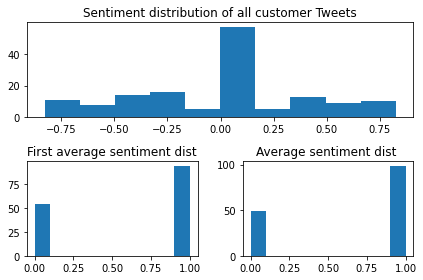

In [56]:
fig=plt.figure()

axs0=plt.subplot(211)
axs0.hist(customers["sentiment"])
axs0.set_title("Sentiment distribution of all customer Tweets")

axs1=plt.subplot(223)
axs1.hist(customer_first["first_sentiment"])
axs1.set_title("First average sentiment dist")

axs2=plt.subplot(224)
axs2.hist(customer_first["classification"])
axs2.set_title("Average sentiment dist ")


plt.tight_layout()
fig.savefig("customer_dist.png")
fig.show()


In [57]:
nltk.download('averaged_perceptron_tagger')

def encode_tweets(df):
  count=0
  encoded=[]
  embedding={}
  for scentence in df.tweet:
    encode=[]
    token=nltk.word_tokenize(scentence.lower())

    token=[ele for word_tuple in nltk.pos_tag(token) for ele in word_tuple ]

    for word in token:
      if word not in embedding:
        embedding[word]=count
        count+=1
      encode.append(embedding[word])
    encoded.append(encode)
  return (encoded)

#endoce the natural text into something the network will be able to read
encoded=encode_tweets(customer_first)

#replace the raw text with the encoded text
customer_first['tweet']=encoded


customer_first

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,author_id,tweet,first_sentiment,classification
6,115712,"[0, 1, 2, 1, 3, 4, 5, 6, 7, 8, 9, 1, 10, 1]",0.0,0
12,115713,"[0, 11, 12, 13, 14, 15, 16, 17, 18, 6, 19, 17,...",0.0,0
14,115715,"[0, 11, 12, 13, 42, 43, 44, 1, 45, 17, 9, 1, 4...",1.0,1
23,115716,"[69, 11, 70, 6, 71, 4, 72, 6, 73, 25, 74, 1, 7...",0.0,1
25,115717,"[81, 1, 0, 37, 82, 1, 33, 33, 22, 23, 9, 1, 10...",1.0,1
...,...,...,...,...
633,115915,"[1192, 1, 238, 11, 1033, 25, 56, 23, 125, 25, ...",0.0,0
635,115916,"[143, 6, 29, 29, 70, 6, 1195, 1, 456, 4, 1196,...",0.0,0
643,115918,"[0, 1, 1185, 1, 0, 1, 1200, 13, 5, 6, 0, 1, 12...",1.0,1
645,115919,"[0, 1, 1206, 15, 238, 21, 44, 25, 984, 17, 112...",0.0,0


# Dividing train and test data

In [58]:
#train test split the data should be 80 20 by default 
#fit data into the models 

#split the data into train and test subsets
train_text, test_text, train_sent, test_sent=train_test_split(customer_first['tweet'], 
                                                              customer_first['classification'])
num_classes=3

train_text=train_text.values
test_text=test_text.values

#pad the text for uniformity on length
train_text=sequence.pad_sequences(train_text, maxlen=225)
test_text=sequence.pad_sequences(test_text, maxlen=225)

train_sent=train_sent.values
test_sent=test_sent.values
train_sent=keras.utils.to_categorical(train_sent)
test_sent=keras.utils.to_categorical(test_sent)

test_text.shape



(37, 225)

# Cnn model 

In [59]:
#Cnn libraries 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.layers import Conv1D, MaxPooling1D, Flatten, AveragePooling1D, Embedding
from tensorflow.keras.utils import to_categorical, plot_model

# Building the model

In [60]:
word_dict=10000

num_labels=2
input_shape=test_text.shape
batch_size=128
kernel_size=3
pool_size=2
filters=64
dropout=0.2
epochs=5



StopWatch.start("cnn_model_building")

cnn_model=Sequential()

cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
cnn_model.add(MaxPooling1D(pool_size))

cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
cnn_model.add(MaxPooling1D(pool_size))

cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
cnn_model.add(MaxPooling1D(pool_size))

cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dropout(dropout))
cnn_model.add(Dense(num_labels))
cnn_model.add(Activation('softmax'))
cnn_model.summary()
plot_model(cnn_model, to_file='cnn_model.png', show_shapes=True)

StopWatch.stop("cnn_model_building")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 37, 64)            43264     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 18, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 18, 64)            12352     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 9, 64)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 4, 64)            

# Compile 

In [61]:
StopWatch.start("cnn_compile")
cnn_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
StopWatch.stop("cnn_compile")

# Model Fit

In [62]:
StopWatch.start("cnn_train")
cnn_model.fit(train_text, train_sent, batch_size=batch_size,epochs=epochs)
StopWatch.stop("cnn_train")

Epoch 1/5


ValueError: ignored

# Predicting

In [ ]:
StopWatch.Start("predict")

predicted=cnn_model.predict(text_text)

StopWatch.Stop("predict")

# Evaluate

In [ ]:
StopWatch.start("cnn_evaluate")
cnn_loss, cnn_accuracy=cnn_model.evaluate(predicted, test_sent, batch_size = batch_size)
print("CNN Accuracy: %.1f%%" %(100.0*cnn_accuracy))
StopWatch.stop("cnn_evaluate")

In [ ]:
StopWatch.benchmark()